In [1]:
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


In [2]:
import torch

In [3]:
class_names = ['ReferableDR','NonReferableDR']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
''' faster
down load trained models and images from kaggle
https://www.kaggle.com/adamhuan/modelsdiabeticretinopathy
to get modelsdiabeticretinopathy.zip using API kaggle.json (need to get a new kaggle.json to download the files everytime)
Using the methods described at:
https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
'''
#copy kaggle.json to colab platform and run
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download adamhuan/modelsdiabeticretinopathy
! unzip modelsdiabeticretinopathy.zip

''' slower
or download archive.zip and move it to colab's gdrive, then run
! unzip archive.zip
to get
./images/DS000DGS.JPG
./images/DS000DGS.png
./models/model_final.pth
./models/best_resnext_model_ft_DR512.pth

'''

mkdir: cannot create directory ‘/root/.kaggle’: File exists
modelsdiabeticretinopathy.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  modelsdiabeticretinopathy.zip
replace 20051019_38557_0100_PP.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 20051019_38557_0100_PP.tif  
  inflating: images/DS000DGS.JPG     
  inflating: images/DS000DGS.png     
  inflating: models/best_resnext_model_ft_DR512.pth  
  inflating: models/model_final.pth  


" slower\nor download archive.zip and move it to colab's gdrive, then run\n! unzip archive.zip\nto get\n./images/DS000DGS.JPG\n./images/DS000DGS.png\n./models/model_final.pth\n./models/best_resnext_model_ft_DR512.pth\n\n"

In [5]:
import os
model_pth='./models/best_resnext_model_ft_DR512.pth'
if os.path.exists(model_pth):
    model_512 = torch.load(model_pth, map_location=device)
    print('Loaded resnext model from this run.')

Loaded resnext model from this run.


In [6]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.10.0+cu111 False


In [7]:
import torchvision
from torchvision import transforms, utils, datasets, models
preprocess512 = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

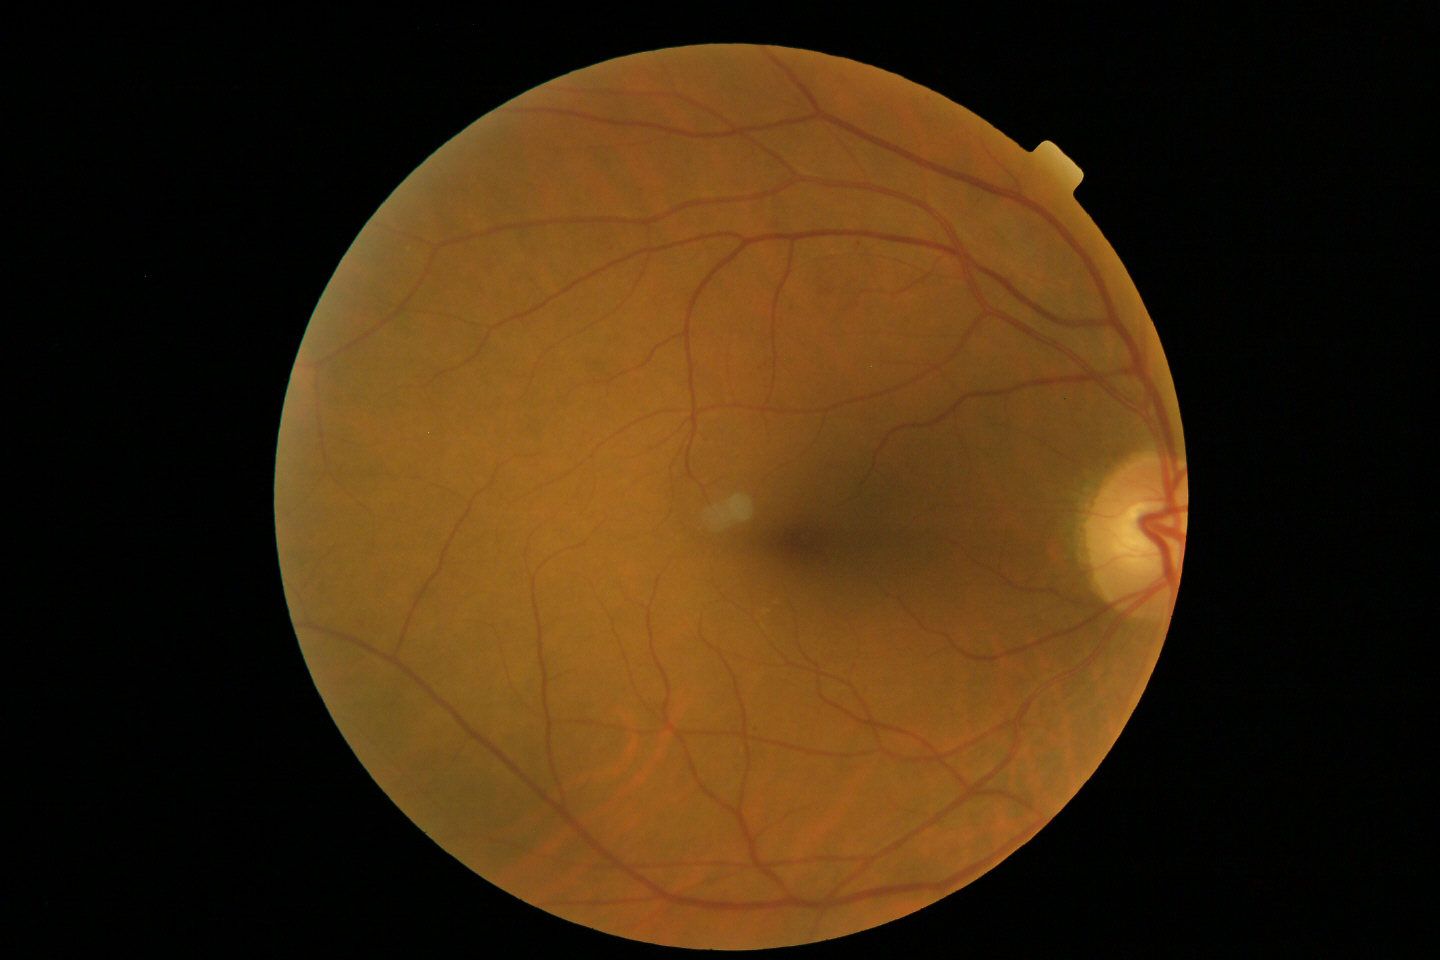

In [8]:
from PIL import Image
# e-ophtha dataset image with 6 MA's
# No DR_level is available
filename = './images/DS000DGS.JPG'
input_image1 = Image.open(filename)
input_image1

In [9]:
# 512
input_tensor = preprocess512(input_image1)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
 #       model_conv.to('cuda')
    
with torch.no_grad():
    # output = model_conv(input_batch)
    output = model_512(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
_, preds1 = torch.max(output, 1)

print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)
if probabilities[0]>probabilities[1]:
    print(class_names[0])
else:
    print(class_names[1])

tensor([-1.4500,  1.5103])
tensor([0.0493, 0.9507])
NonReferableDR


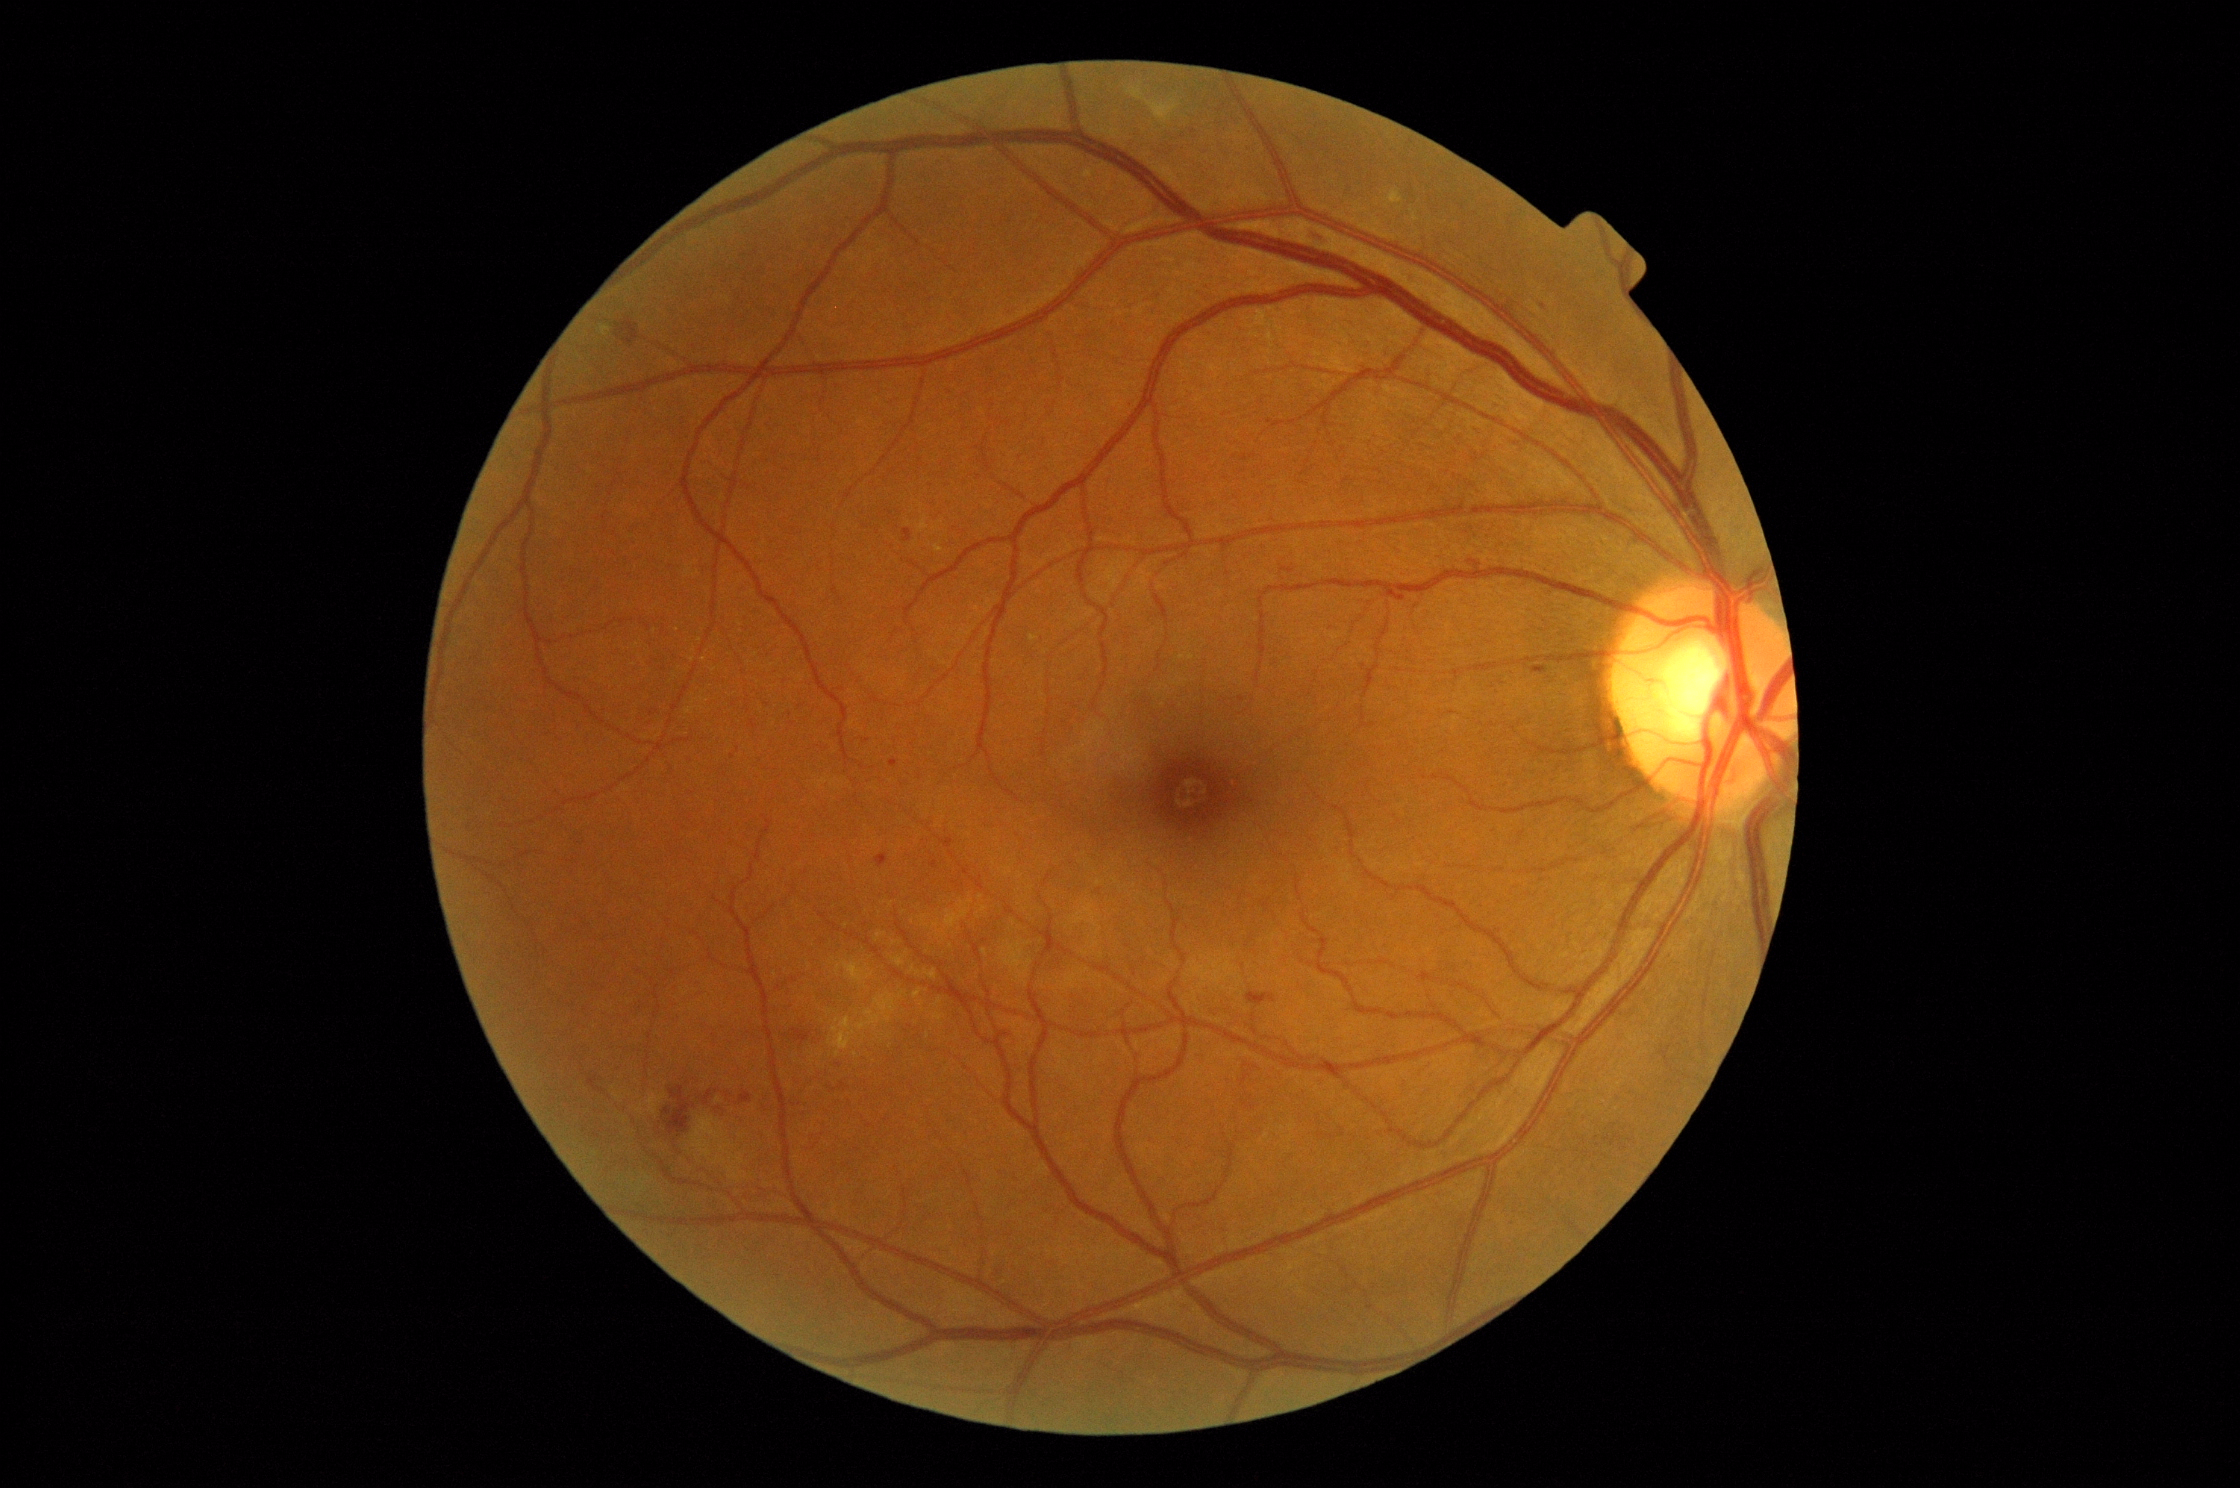

In [10]:
# Messidor dataset image
# 20051019_38557_0100_PP.tif was graded as DR_level=3
filename = './20051019_38557_0100_PP.tif'
input_image2 = Image.open(filename)
input_image2

In [11]:
# 512
input_tensor = preprocess512(input_image2)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
 #       model_conv.to('cuda')
    
with torch.no_grad():
    # output = model_conv(input_batch)
    output = model_512(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
_, preds1 = torch.max(output, 1)

print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)
if probabilities[0]>probabilities[1]:
    print(class_names[0])
else:
    print(class_names[1])

tensor([ 3.3137, -3.4203])
tensor([0.9988, 0.0012])
ReferableDR
